In [ ]:
#1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2023 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) 
# #masked out over land - save this to your computer. 
# The land sea mask is available here: 
# [https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc](https://thredds.rda.ucar.edu/thredds/catalog/files/g/ds633.0/e5.oper.invariant/197901/catalog.html?dataset=files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc)


#Grab monthly mean data from era-5. Feel free to access only every 4th data point within dataset to save time. First grab data of monthly means of SST, total column of water vapor. Boxed out over the Pacific Ocean
#Mask out points over land using the file given. One of the values in file is for land, another for ocean. Take out land for SST. 
#Skills Check: Access all of the data in the climatology, plot maps of the main SST and main total column water vapor for entire period of record. Do make the SST masked over land because it doesn't make sense to have SST over land even if values in dataset. 
#Assignment, look at statistical analysis based on time series. De-seasonalize data, get rid of annual cycle of averages in dataset. 
# Also detrend data (get rid of any longterm variation), for example "climate change"  - will subtract w linear regression, plot anomalies
#Standardize the SST anomalies so that they are relative to number of standard deviations from the mean. Do that to help with the diff magnitudes in diff regions, want to characterize variability in a standardized way. 
#Once get that dataset, will perform the PCA/EOF analysis. 

In [31]:
#Access the ERA-5 data using xarray and the netcdf4 engine on the thredds software webserver. Dataset 633.1. Want the full collection dataset. Sea_surface_temp access URL
import xarray as xr

In [32]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof
from eofs.examples import example_data_path


In [60]:
#Download data from threads, save into variable, import only the variables for total column water vapor and SST. Slice for desired lat and lon for every 4th data point

ds = xr.open_dataset('https://thredds.rda.ucar.edu/thredds/dodsC/aggregations/g/ds633.1/2/TP',
                     chunks={'time':'500MB'})

variables = ['Total_column_water_vapour_surface_Mixed_intervals_Average',
        'Sea_surface_temperature_surface_Mixed_intervals_Average']
#select the two needed variables every 4th point to get 1 degree resolution
ds = ds[variables].sel(lat=slice(65, -65, 4), lon=slice(120, 300, 4))

ds.to_netcdf('raw_data.nc')

In [62]:
#save Land Sea Mask. Drop "time" variable since it does not apply
lsm = xr.open_dataset('https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc', engine='netcdf4')

#lsm look at info regarding lsm. "LSM" is a binary data variable, likely indicating where land is or is not. Time dimension is single. 

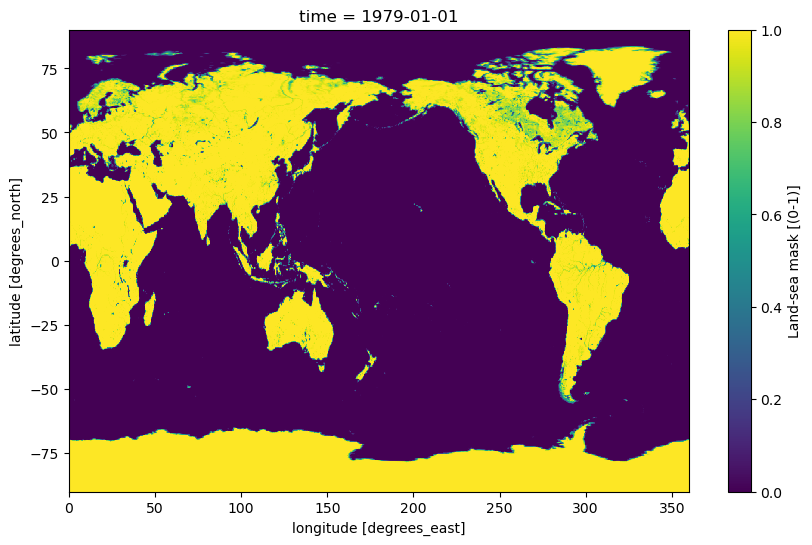

In [78]:
plt.figure(figsize=(10, 6))
lsm['LSM'].plot()

In [164]:
#use squeeze to remove single dimension so that mask maps to lats/lons. filter data so that mask only returns ocean points. 
mask = (lsm.LSM == 0 ).squeeze(['time'], drop=True)

#rename the dimensions so that they can be overlayed with the SST monthly dataset
mask = mask.rename({'latitude':'lat','longitude':'lon'})

In [165]:
#broadcast onto the ds dims

mask_broadcast, ds_broadcast = xr.broadcast(mask, ds)

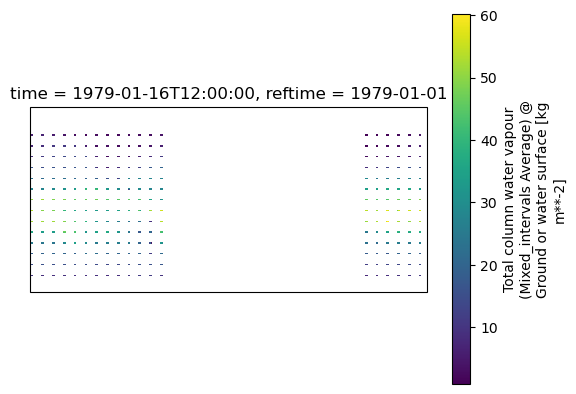

In [166]:
ds_oceans = ds_broadcast.where(mask_broadcast, drop = True)
ax = plt.axes(projection=ccrs.PlateCarree())
ds_oceans['Total_column_water_vapour_surface_Mixed_intervals_Average'].isel(time=0).plot()

#This mask is not working. Time to use the other idea

In [169]:
#if there is SST, then there is no land because it's ocean temp
sst_mask = (ds['Sea_surface_temperature_surface_Mixed_intervals_Average'] > 0).compute()

# Apply the mask to the overall dataset
ds_masked = ds.where(sst_mask, drop=True)


In [170]:
ds_masked_avg= ds_masked.mean(dim='time')

/Users/marygan/anaconda3/envs/ModulesEnv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


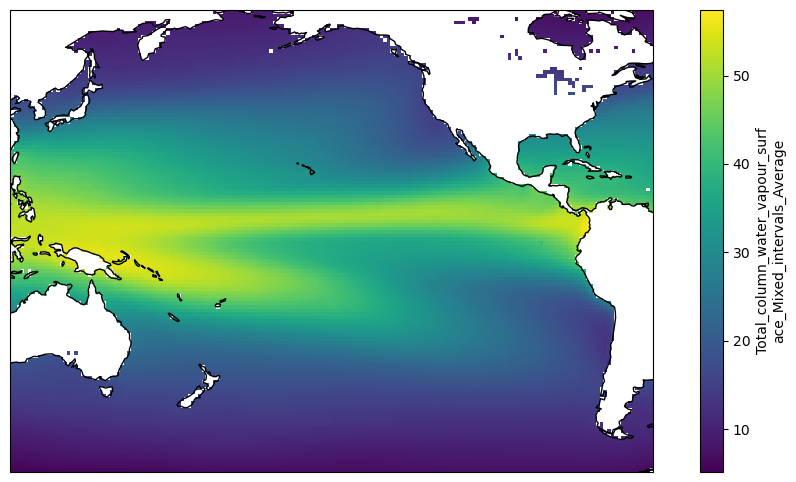

In [176]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ds_masked_avg["Total_column_water_vapour_surface_Mixed_intervals_Average"].plot(transform=ccrs.PlateCarree())

/Users/marygan/anaconda3/envs/ModulesEnv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


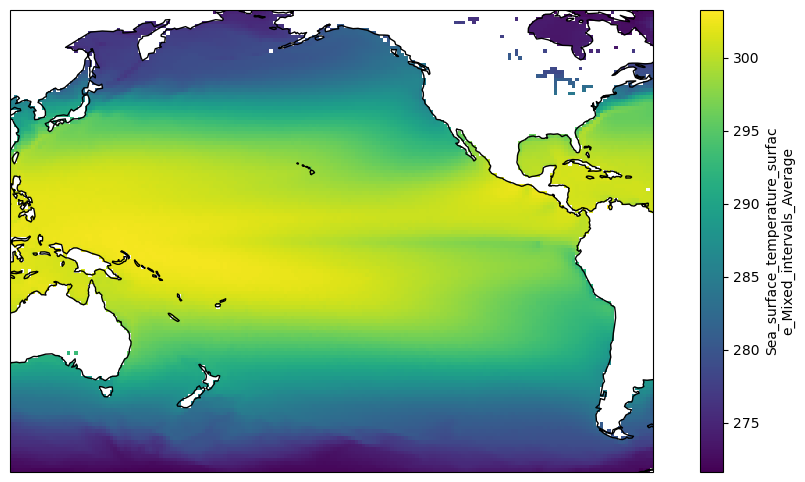

In [177]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ds_masked_avg['Sea_surface_temperature_surface_Mixed_intervals_Average'].plot(transform=ccrs.PlateCarree())